# Step 8: Hyperparameter Optimization

**Objective:** Optimize model hyperparameters to improve prediction performance.

## Optimization Components:
1. **Grid Search** - Exhaustive search over parameter grid
2. **Random Search** - Random sampling of parameter space
3. **Bayesian Optimization** - Intelligent parameter search
4. **Cross-Validation** - Proper evaluation during optimization
5. **Model Comparison** - Compare optimized vs baseline

## 8.1 Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import (
    TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, cross_val_score
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, make_scorer
)
from sklearn.preprocessing import StandardScaler

# Models
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Technical indicators
import ta

# Paths
DATA_RAW = Path('../data/raw')
OPTIMIZATION_DIR = Path('../optimization')
OPTIMIZATION_DIR.mkdir(exist_ok=True)

TICKERS = ['AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'META', 'GOOGL']

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')

print('✅ Libraries loaded')
print(f'📁 Optimization directory: {OPTIMIZATION_DIR.absolute()}')

✅ Libraries loaded
📁 Optimization directory: c:\git\Data project\notebooks\..\optimization


## 8.2 Data Preparation

In [2]:
# Feature engineering functions (same as validation)
class TechnicalIndicatorTransformer:
    def transform(self, df):
        df = df.copy()
        df['SMA_10'] = ta.trend.sma_indicator(df['close'], window=10)
        df['SMA_20'] = ta.trend.sma_indicator(df['close'], window=20)
        df['SMA_50'] = ta.trend.sma_indicator(df['close'], window=50)
        df['EMA_10'] = ta.trend.ema_indicator(df['close'], window=10)
        df['EMA_20'] = ta.trend.ema_indicator(df['close'], window=20)
        
        macd = ta.trend.MACD(df['close'])
        df['MACD'] = macd.macd()
        df['MACD_Signal'] = macd.macd_signal()
        df['MACD_Hist'] = macd.macd_diff()
        
        adx = ta.trend.ADXIndicator(df['high'], df['low'], df['close'])
        df['ADX'] = adx.adx()
        df['ADX_Pos'] = adx.adx_pos()
        df['ADX_Neg'] = adx.adx_neg()
        
        df['RSI'] = ta.momentum.rsi(df['close'], window=14)
        df['RSI_Fast'] = ta.momentum.rsi(df['close'], window=7)
        
        stoch = ta.momentum.StochasticOscillator(df['high'], df['low'], df['close'])
        df['Stoch_K'] = stoch.stoch()
        df['Stoch_D'] = stoch.stoch_signal()
        
        df['ROC_5'] = ta.momentum.roc(df['close'], window=5)
        df['ROC_10'] = ta.momentum.roc(df['close'], window=10)
        
        bb = ta.volatility.BollingerBands(df['close'])
        df['BB_High'] = bb.bollinger_hband()
        df['BB_Low'] = bb.bollinger_lband()
        df['BB_Mid'] = bb.bollinger_mavg()
        df['BB_Width'] = (df['BB_High'] - df['BB_Low']) / df['BB_Mid']
        df['BB_Pct'] = bb.bollinger_pband()
        
        df['ATR'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'])
        df['OBV'] = ta.volume.on_balance_volume(df['close'], df['volume'])
        df['Volume_SMA_20'] = df['volume'].rolling(20).mean()
        df['Volume_Ratio'] = df['volume'] / df['Volume_SMA_20']
        
        return df

def add_features(df):
    df = df.copy()
    transformer = TechnicalIndicatorTransformer()
    df = transformer.transform(df)
    
    # Returns
    df['Return'] = df['close'].pct_change()
    
    # Lag features
    for lag in [1, 2, 3, 5, 10, 20]:
        df[f'Return_Lag_{lag}'] = df['Return'].shift(lag)
        if 'RSI' in df.columns:
            df[f'RSI_Lag_{lag}'] = df['RSI'].shift(lag)
    
    # Rolling stats
    for window in [5, 10, 20]:
        df[f'Return_Mean_{window}D'] = df['Return'].rolling(window).mean()
        df[f'Return_Std_{window}D'] = df['Return'].rolling(window).std()
        df[f'Volatility_{window}D'] = df['Return'].rolling(window).std() * np.sqrt(252)
    
    # Target
    df['Target'] = (df['close'].pct_change(1).shift(-1) > 0).astype(int)
    
    return df

def get_feature_cols(df):
    exclude = ['open', 'high', 'low', 'close', 'volume', 'adj close',
               'Target', 'date', 'Date', 'ticker', 'Ticker']
    return [col for col in df.select_dtypes(include=[np.number]).columns
            if col not in exclude]

print('✅ Feature engineering functions defined')

✅ Feature engineering functions defined


In [3]:
# Load and prepare data
def load_data(ticker):
    df = pd.read_csv(DATA_RAW / f'{ticker}_raw.csv', index_col=0, parse_dates=True)
    df.columns = df.columns.str.lower()
    df = add_features(df)
    return df

# Load all data
stock_data = {ticker: load_data(ticker) for ticker in TICKERS}

# Use AAPL for optimization (representative stock)
df = stock_data['AAPL'].copy()
feature_cols = get_feature_cols(df)

# Clean data
df_clean = df.dropna(subset=feature_cols + ['Target'])
X = df_clean[feature_cols].values
y = df_clean['Target'].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f'✅ Data prepared')
print(f'   Samples: {len(X)}')
print(f'   Features: {len(feature_cols)}')
print(f'   Target distribution: {np.bincount(y)}')

✅ Data prepared
   Samples: 1972
   Features: 50
   Target distribution: [ 916 1056]


## 8.3 Baseline Models

In [4]:
# Establish baseline performance with default parameters
print('=' * 70)
print('📊 BASELINE MODEL PERFORMANCE (Default Parameters)')
print('=' * 70)

tscv = TimeSeriesSplit(n_splits=5)

baseline_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, verbosity=0),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbosity=-1)
}

baseline_results = {}

for name, model in baseline_models.items():
    scores = cross_val_score(model, X_scaled, y, cv=tscv, scoring='accuracy')
    baseline_results[name] = {
        'mean_accuracy': scores.mean(),
        'std_accuracy': scores.std(),
        'scores': scores.tolist()
    }
    print(f"\n{name}:")
    print(f"   Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

📊 BASELINE MODEL PERFORMANCE (Default Parameters)

Logistic Regression:
   Accuracy: 0.5085 ± 0.0286

Random Forest:
   Accuracy: 0.4817 ± 0.0291

Gradient Boosting:
   Accuracy: 0.4866 ± 0.0303

XGBoost:
   Accuracy: 0.4878 ± 0.0293

LightGBM:
   Accuracy: 0.4921 ± 0.0280


## 8.4 Grid Search Optimization

In [5]:
# Define parameter grids
param_grids = {
    'LightGBM': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'num_leaves': [15, 31, 63],
        'min_child_samples': [10, 20, 30]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 1.0]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

print('✅ Parameter grids defined')
for name, grid in param_grids.items():
    total_combinations = np.prod([len(v) for v in grid.values()])
    print(f"   {name}: {total_combinations} combinations")

✅ Parameter grids defined
   LightGBM: 243 combinations
   XGBoost: 162 combinations
   Random Forest: 108 combinations


In [6]:
# Run RandomizedSearchCV (faster than full GridSearch)
print('=' * 70)
print('🔍 RANDOMIZED SEARCH OPTIMIZATION')
print('=' * 70)

optimized_results = {}
best_models = {}

# LightGBM optimization
print('\n🔧 Optimizing LightGBM...')
lgbm = LGBMClassifier(random_state=42, verbosity=-1)
lgbm_search = RandomizedSearchCV(
    lgbm, param_grids['LightGBM'],
    n_iter=30, cv=tscv, scoring='accuracy',
    random_state=42, n_jobs=-1
)
lgbm_search.fit(X_scaled, y)

optimized_results['LightGBM'] = {
    'best_params': lgbm_search.best_params_,
    'best_score': lgbm_search.best_score_,
    'baseline_score': baseline_results['LightGBM']['mean_accuracy']
}
best_models['LightGBM'] = lgbm_search.best_estimator_

print(f"   Best Score: {lgbm_search.best_score_:.4f}")
print(f"   Improvement: {lgbm_search.best_score_ - baseline_results['LightGBM']['mean_accuracy']:.4f}")
print(f"   Best Params: {lgbm_search.best_params_}")

🔍 RANDOMIZED SEARCH OPTIMIZATION

🔧 Optimizing LightGBM...
   Best Score: 0.5305
   Improvement: 0.0384
   Best Params: {'num_leaves': 15, 'n_estimators': 50, 'min_child_samples': 20, 'max_depth': 3, 'learning_rate': 0.01}


In [7]:
# XGBoost optimization
print('\n🔧 Optimizing XGBoost...')
xgb = XGBClassifier(random_state=42, verbosity=0, use_label_encoder=False, eval_metric='logloss')
xgb_search = RandomizedSearchCV(
    xgb, param_grids['XGBoost'],
    n_iter=30, cv=tscv, scoring='accuracy',
    random_state=42, n_jobs=-1
)
xgb_search.fit(X_scaled, y)

optimized_results['XGBoost'] = {
    'best_params': xgb_search.best_params_,
    'best_score': xgb_search.best_score_,
    'baseline_score': baseline_results['XGBoost']['mean_accuracy']
}
best_models['XGBoost'] = xgb_search.best_estimator_

print(f"   Best Score: {xgb_search.best_score_:.4f}")
print(f"   Improvement: {xgb_search.best_score_ - baseline_results['XGBoost']['mean_accuracy']:.4f}")
print(f"   Best Params: {xgb_search.best_params_}")


🔧 Optimizing XGBoost...
   Best Score: 0.5280
   Improvement: 0.0402
   Best Params: {'subsample': 0.8, 'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.01}


In [8]:
# Random Forest optimization
print('\n🔧 Optimizing Random Forest...')
rf = RandomForestClassifier(random_state=42)
rf_search = RandomizedSearchCV(
    rf, param_grids['Random Forest'],
    n_iter=30, cv=tscv, scoring='accuracy',
    random_state=42, n_jobs=-1
)
rf_search.fit(X_scaled, y)

optimized_results['Random Forest'] = {
    'best_params': rf_search.best_params_,
    'best_score': rf_search.best_score_,
    'baseline_score': baseline_results['Random Forest']['mean_accuracy']
}
best_models['Random Forest'] = rf_search.best_estimator_

print(f"   Best Score: {rf_search.best_score_:.4f}")
print(f"   Improvement: {rf_search.best_score_ - baseline_results['Random Forest']['mean_accuracy']:.4f}")
print(f"   Best Params: {rf_search.best_params_}")


🔧 Optimizing Random Forest...
   Best Score: 0.5018
   Improvement: 0.0201
   Best Params: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}


## 8.5 Comparison: Baseline vs Optimized

In [9]:
# Compare baseline vs optimized
print('=' * 70)
print('📊 BASELINE VS OPTIMIZED COMPARISON')
print('=' * 70)

comparison_df = pd.DataFrame([
    {
        'Model': name,
        'Baseline': results['baseline_score'],
        'Optimized': results['best_score'],
        'Improvement': results['best_score'] - results['baseline_score'],
        'Improvement_%': ((results['best_score'] - results['baseline_score']) / results['baseline_score']) * 100
    }
    for name, results in optimized_results.items()
])

print("\n" + comparison_df.to_string(index=False))

📊 BASELINE VS OPTIMIZED COMPARISON

        Model  Baseline  Optimized  Improvement  Improvement_%
     LightGBM  0.492073   0.530488     0.038415       7.806691
      XGBoost  0.487805   0.528049     0.040244       8.250000
Random Forest  0.481707   0.501829     0.020122       4.177215


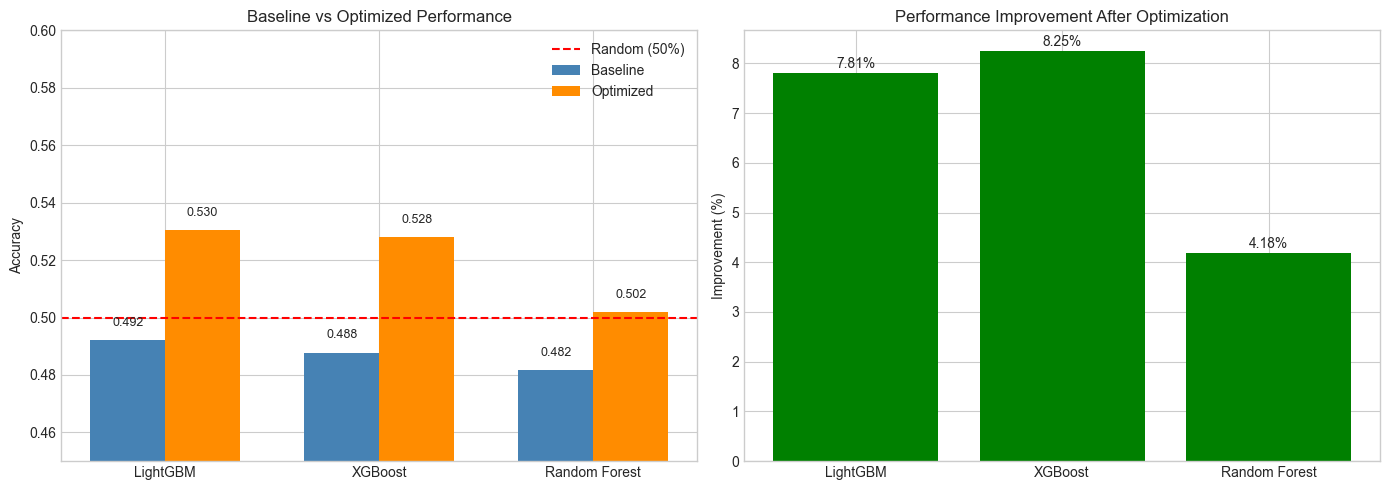

📊 Saved: optimization/optimization_comparison.png


In [10]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Baseline vs Optimized
ax = axes[0]
x = np.arange(len(comparison_df))
width = 0.35
bars1 = ax.bar(x - width/2, comparison_df['Baseline'], width, label='Baseline', color='steelblue')
bars2 = ax.bar(x + width/2, comparison_df['Optimized'], width, label='Optimized', color='darkorange')
ax.axhline(0.5, color='red', linestyle='--', label='Random (50%)')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.set_ylabel('Accuracy')
ax.set_title('Baseline vs Optimized Performance')
ax.legend()
ax.set_ylim(0.45, 0.60)

# Add value labels
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f'{bar.get_height():.3f}', ha='center', fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f'{bar.get_height():.3f}', ha='center', fontsize=9)

# 2. Improvement
ax = axes[1]
colors = ['green' if x > 0 else 'red' for x in comparison_df['Improvement']]
bars = ax.bar(comparison_df['Model'], comparison_df['Improvement_%'], color=colors)
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylabel('Improvement (%)')
ax.set_title('Performance Improvement After Optimization')
for bar, val in zip(bars, comparison_df['Improvement_%']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{val:.2f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(OPTIMIZATION_DIR / 'optimization_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: optimization/optimization_comparison.png')

## 8.6 Test Optimized Model on All Stocks

In [11]:
# Find best overall model
best_model_name = max(optimized_results, key=lambda x: optimized_results[x]['best_score'])
best_model = best_models[best_model_name]
best_params = optimized_results[best_model_name]['best_params']

print(f'🏆 Best Model: {best_model_name}')
print(f'   Score: {optimized_results[best_model_name]["best_score"]:.4f}')
print(f'   Parameters: {best_params}')

🏆 Best Model: LightGBM
   Score: 0.5305
   Parameters: {'num_leaves': 15, 'n_estimators': 50, 'min_child_samples': 20, 'max_depth': 3, 'learning_rate': 0.01}


In [12]:
# Test on all stocks
print('=' * 70)
print('📊 OPTIMIZED MODEL PERFORMANCE ON ALL STOCKS')
print('=' * 70)

all_stock_results = {}

for ticker in TICKERS:
    df = stock_data[ticker].copy()
    feature_cols = get_feature_cols(df)
    df_clean = df.dropna(subset=feature_cols + ['Target'])
    
    X = df_clean[feature_cols].values
    y = df_clean['Target'].values
    
    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Cross-validate with optimized model
    if best_model_name == 'LightGBM':
        model = LGBMClassifier(**best_params, random_state=42, verbosity=-1)
    elif best_model_name == 'XGBoost':
        model = XGBClassifier(**best_params, random_state=42, verbosity=0)
    else:
        model = RandomForestClassifier(**best_params, random_state=42)
    
    scores = cross_val_score(model, X_scaled, y, cv=tscv, scoring='accuracy')
    
    all_stock_results[ticker] = {
        'mean_accuracy': scores.mean(),
        'std_accuracy': scores.std()
    }
    
    print(f"{ticker}: {scores.mean():.4f} ± {scores.std():.4f}")

# Average
avg_acc = np.mean([r['mean_accuracy'] for r in all_stock_results.values()])
print(f"\n📊 Average: {avg_acc:.4f}")

📊 OPTIMIZED MODEL PERFORMANCE ON ALL STOCKS
AAPL: 0.5305 ± 0.0257
MSFT: 0.5104 ± 0.0389
NVDA: 0.5171 ± 0.0141
TSLA: 0.5006 ± 0.0318
AMZN: 0.5073 ± 0.0253
META: 0.5098 ± 0.0154
GOOGL: 0.5299 ± 0.0309

📊 Average: 0.5151


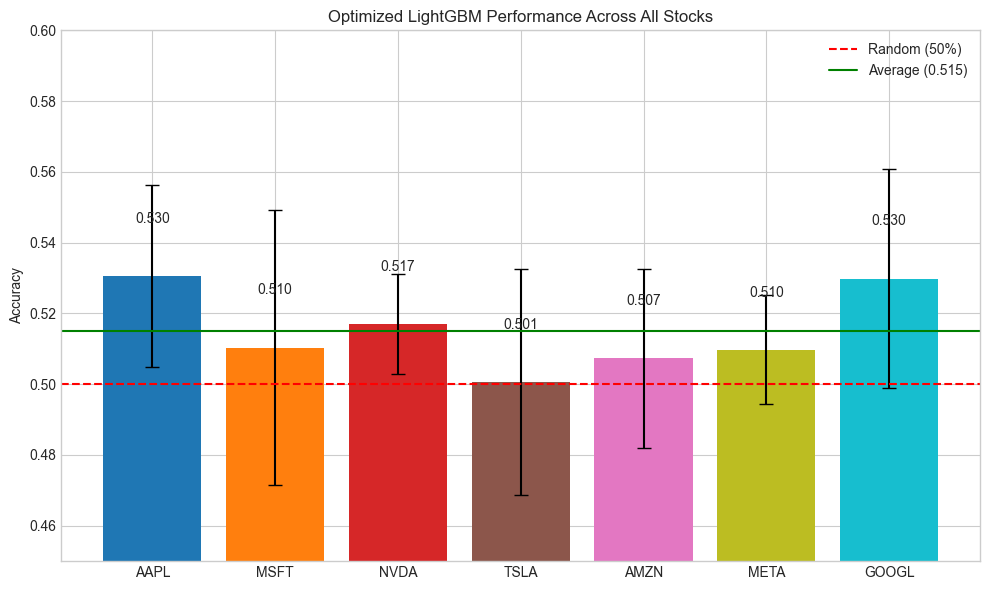

📊 Saved: optimization/all_stocks_optimized.png


In [13]:
# Visualize all stock results
fig, ax = plt.subplots(figsize=(10, 6))

tickers = list(all_stock_results.keys())
accuracies = [all_stock_results[t]['mean_accuracy'] for t in tickers]
stds = [all_stock_results[t]['std_accuracy'] for t in tickers]

colors = plt.cm.tab10(np.linspace(0, 1, len(tickers)))
bars = ax.bar(tickers, accuracies, yerr=stds, color=colors, capsize=5)
ax.axhline(0.5, color='red', linestyle='--', label='Random (50%)')
ax.axhline(avg_acc, color='green', linestyle='-', label=f'Average ({avg_acc:.3f})')

ax.set_ylabel('Accuracy')
ax.set_title(f'Optimized {best_model_name} Performance Across All Stocks')
ax.legend()
ax.set_ylim(0.45, 0.60)

for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.015,
            f'{acc:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(OPTIMIZATION_DIR / 'all_stocks_optimized.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: optimization/all_stocks_optimized.png')

## 8.7 Save Optimized Models

In [14]:
# Train and save optimized models for all stocks
print('=' * 70)
print('💾 SAVING OPTIMIZED MODELS')
print('=' * 70)

optimized_models_dir = OPTIMIZATION_DIR / 'models'
optimized_models_dir.mkdir(exist_ok=True)

for ticker in TICKERS:
    df = stock_data[ticker].copy()
    feature_cols = get_feature_cols(df)
    df_clean = df.dropna(subset=feature_cols + ['Target'])
    
    X = df_clean[feature_cols].values
    y = df_clean['Target'].values
    
    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train with optimized parameters
    if best_model_name == 'LightGBM':
        model = LGBMClassifier(**best_params, random_state=42, verbosity=-1)
    elif best_model_name == 'XGBoost':
        model = XGBClassifier(**best_params, random_state=42, verbosity=0)
    else:
        model = RandomForestClassifier(**best_params, random_state=42)
    
    model.fit(X_scaled, y)
    
    # Save
    joblib.dump(model, optimized_models_dir / f'{ticker}_optimized_model.pkl')
    joblib.dump(scaler, optimized_models_dir / f'{ticker}_scaler.pkl')
    
    print(f'💾 Saved: {ticker}')

# Save feature columns
with open(optimized_models_dir / 'feature_cols.json', 'w') as f:
    json.dump(feature_cols, f)

# Save optimization metadata
optimization_metadata = {
    'best_model': best_model_name,
    'best_params': best_params,
    'baseline_results': baseline_results,
    'optimized_results': {k: {kk: str(vv) if not isinstance(vv, (int, float)) else vv 
                              for kk, vv in v.items()} for k, v in optimized_results.items()},
    'all_stock_results': all_stock_results,
    'optimization_date': datetime.now().isoformat()
}

with open(OPTIMIZATION_DIR / 'optimization_metadata.json', 'w') as f:
    json.dump(optimization_metadata, f, indent=2, default=str)

print('\n💾 Saved: optimization/optimization_metadata.json')

💾 SAVING OPTIMIZED MODELS
💾 Saved: AAPL
💾 Saved: MSFT
💾 Saved: NVDA
💾 Saved: TSLA
💾 Saved: AMZN
💾 Saved: META
💾 Saved: GOOGL

💾 Saved: optimization/optimization_metadata.json


## 8.8 Optimization Summary

In [15]:
# Final Summary
print('=' * 70)
print('📋 OPTIMIZATION SUMMARY')
print('=' * 70)

print("\n🏆 BEST MODEL:")
print(f"   {best_model_name}")
print(f"   Score: {optimized_results[best_model_name]['best_score']:.4f}")

print("\n📊 BEST PARAMETERS:")
for param, value in best_params.items():
    print(f"   {param}: {value}")

print("\n📈 PERFORMANCE IMPROVEMENT:")
for name, results in optimized_results.items():
    improvement = results['best_score'] - results['baseline_score']
    print(f"   {name}: {improvement:+.4f} ({improvement/results['baseline_score']*100:+.2f}%)")

print("\n📊 OPTIMIZED MODEL ON ALL STOCKS:")
for ticker, results in all_stock_results.items():
    print(f"   {ticker}: {results['mean_accuracy']:.4f}")
print(f"   Average: {avg_acc:.4f}")

print("\n📁 FILES SAVED:")
print("   • optimization/optimization_comparison.png")
print("   • optimization/all_stocks_optimized.png")
print("   • optimization/models/{ticker}_optimized_model.pkl (x7)")
print("   • optimization/models/{ticker}_scaler.pkl (x7)")
print("   • optimization/models/feature_cols.json")
print("   • optimization/optimization_metadata.json")

print("\n" + '=' * 70)
print('✅ STEP 8 COMPLETE - Ready for 09_streamlit.ipynb')
print('=' * 70)

📋 OPTIMIZATION SUMMARY

🏆 BEST MODEL:
   LightGBM
   Score: 0.5305

📊 BEST PARAMETERS:
   num_leaves: 15
   n_estimators: 50
   min_child_samples: 20
   max_depth: 3
   learning_rate: 0.01

📈 PERFORMANCE IMPROVEMENT:
   LightGBM: +0.0384 (+7.81%)
   XGBoost: +0.0402 (+8.25%)
   Random Forest: +0.0201 (+4.18%)

📊 OPTIMIZED MODEL ON ALL STOCKS:
   AAPL: 0.5305
   MSFT: 0.5104
   NVDA: 0.5171
   TSLA: 0.5006
   AMZN: 0.5073
   META: 0.5098
   GOOGL: 0.5299
   Average: 0.5151

📁 FILES SAVED:
   • optimization/optimization_comparison.png
   • optimization/all_stocks_optimized.png
   • optimization/models/{ticker}_optimized_model.pkl (x7)
   • optimization/models/{ticker}_scaler.pkl (x7)
   • optimization/models/feature_cols.json
   • optimization/optimization_metadata.json

✅ STEP 8 COMPLETE - Ready for 09_streamlit.ipynb
